# Predicting Character Deaths in Game of Thrones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

from src.preprocess import preprocess_inputs
from src.visualize_correlation import visualize_correlation
from src.data_pipeline import create_pipeline
from src.model_train import create_model
from src.short_results import short_results

## Summary

We build a prediction tool that predicts whether a given character from the Game of Thrones books will survive to the end of the series. To do this, we implement a logistic regression model on a data set containing character information. The model is not able to achieve prediction accuracy any better than 65%. This is likely due to an absence of strong patterns in the plot and cast of characters that would allow us to easily answer such a question.

## Introduction

The popular novel series *Game of Thrones* by George R. R. Martin takes place in a fictional world inspired by medeival Europe. Warfare and violence are central to the plot, leading to frequent casualties among the expansive cast of characters. Exactly which characters are fated to die before the end of the series has become a topic of heated speculation.

In this analysis we try to predict whether a character will come to grief before the end of the series based on that character's attributes. We consider a data set created by Data Society available through data.world, which comprises a comprehensive list of characters appearing in the series. For each character there is a number of attributes, such as whether the character is noble, whether they appeared in a given book in the series, whether a relation of theirs is already dead, and finally whether or not the character is still alive at the end. 

## Methods and Results



A concern of ours having seen the data is that there are a number of columns which are filled almost completely with missing values. These represent information that is only known for a very small minority of characters, like whether their parents are alive and who their heir is. We decided to drop columns that were almost entirely missing values, like **isAliveFather**. In other cases like **House**, where the missing values represent characters who are not noble and thus do not belong to a house, we filled the missing values with a new category like 'No house'. Also these columns contained a great number of unique categories; for simplicity's sake we decided to keep only the most common categories and filled all the other values with 'other'. Finally for age, which is unknown for about half of the characters, we filled missing values with the median age.

We created a heatmap to illustrate the correlation of each feature with **isAlive**. None of the correlations are particularly strong, but they seem to make sense. There is a notable positive correlation with whether the character is alive in book 4, which makes sense given that a character has no chance of being alive at the end of the series if they aren't still alive at book 4. There are also notable negative correlations with the character's popularity and the number of dead realtions the character has, suggesting that popular characters whose families are already depleted tend to survive in the story.


| Stretch/Untouched | ProbDistribution | Accuracy |
| --- | --- | --- |
| Stretched | Gaussian | .843 |

```{figure} ../results/pr_curve.png
---
height: 300px
name: RoC Curve
---
RoC Curve
```


![fishy](./pr_curve.png)


In [2]:
df = pd.read_csv('data/character-predictions_pose.csv')

df.isna().mean()

S.No                 0.000000
plod                 0.000000
name                 0.000000
title                0.517986
male                 0.000000
culture              0.652107
dateOfBirth          0.777492
DateoFdeath          0.771840
mother               0.989209
father               0.986639
heir                 0.988181
house                0.219424
spouse               0.858171
book1                0.000000
book2                0.000000
book3                0.000000
book4                0.000000
book5                0.000000
isAliveMother        0.989209
isAliveFather        0.986639
isAliveHeir          0.988181
isAliveSpouse        0.858171
isMarried            0.000000
isNoble              0.000000
age                  0.777492
numDeadRelations     0.000000
boolDeadRelations    0.000000
isPopular            0.000000
popularity           0.000000
isAlive              0.000000
dtype: float64

In [3]:
fill_nan_cols = {'title':'No Title',
                'house':'No House',
                'dateOfBirth':'dateOfBirth',
                'culture':'Unknown'}

drop_cols = ['S.No',
            'plod',
            'name',
            'heir',
            'isAliveMother',
            'isAliveFather',
            'isAliveHeir',
            'isAliveSpouse',
            'father',
            'mother',
            'spouse',
            'age',
            'DateoFdeath']

less_frequent_cols = ['title','culture','house']

X = preprocess_inputs(df,fill_nan_cols,drop_cols,less_frequent_cols)

Using this cleaned data set, we then constructed a column transformer to prepare the data for machine learning purposes. We tried a selection of different machine learning models: dummy, k-NN, SVM, and logistic regression. We found that the logistic regression model performed the best based on f1 score, with **test_f1** of 0.427, and so undertook randomized hyper-parameter optimization to fine-tune that model.

<Axes: title={'center': 'Features Correlating isAlive'}>

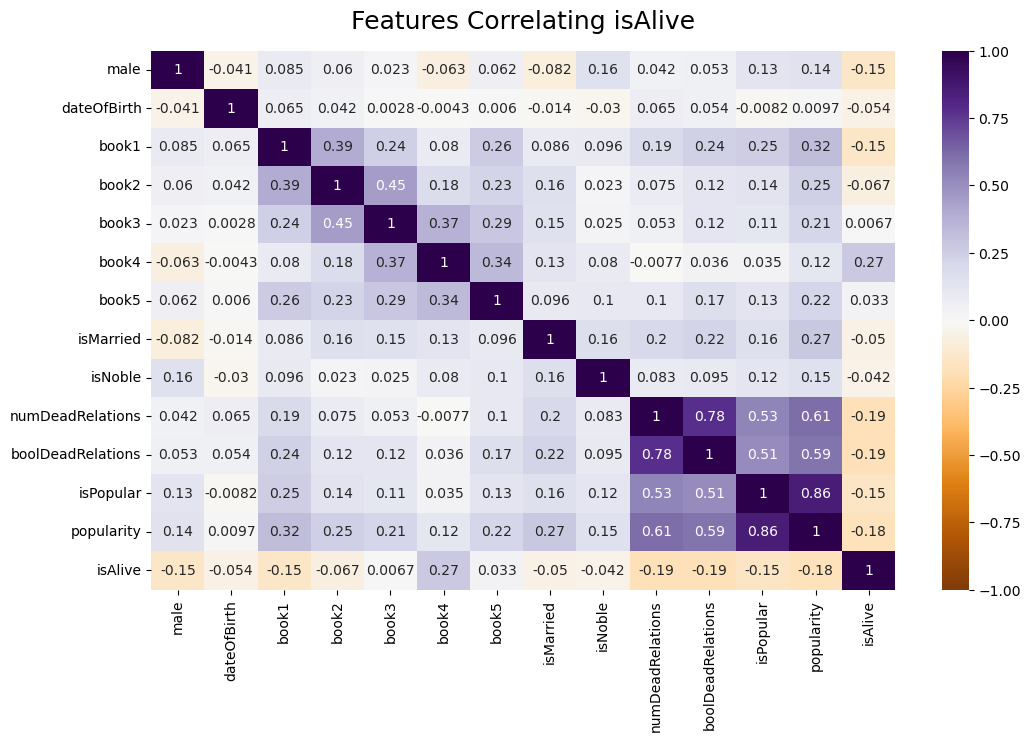

In [4]:
visualize_correlation(X)

In [5]:
y = df["isAlive"]
y = y.map({0: 1, 1: 0}) #positive class is the dead character 
X.drop("isAlive", inplace=True, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

preprocessor = create_pipeline()

In [6]:
best_model, random_search = create_model(X_train, y_train, preprocessor, save_path=None, cv=5)

In [7]:
results = short_results(random_search)
results

,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__class_weight,mean_test_score,mean_fit_time,mean_train_score
0,0.000002,500,balanced,0.538163,0.062280,0.524183
1,0.0,2000,balanced,0.537184,0.064761,0.524049
2,16.237767,2000,balanced,0.519687,0.151212,0.529217
3,69.51928,2000,balanced,0.518309,0.161608,0.529784
4,297.635144,1500,balanced,0.517774,0.158645,0.529661


Having found this best performing model, we tried it out by deploying it on the test set.

In [8]:
y_pred = best_model.predict(X_test)

class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       294
           1       0.37      0.68      0.47        96

    accuracy                           0.63       390
   macro avg       0.61      0.65      0.59       390
weighted avg       0.73      0.63      0.66       390



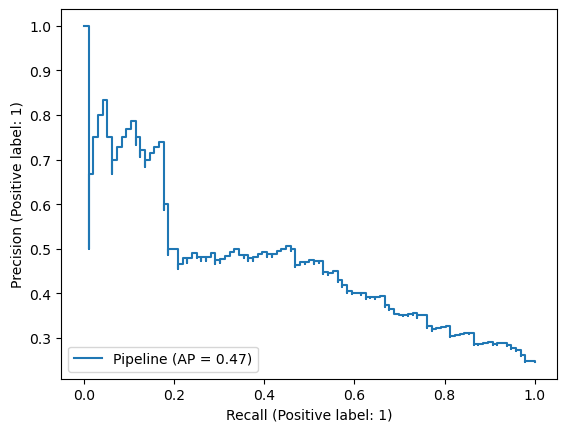

In [9]:
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)

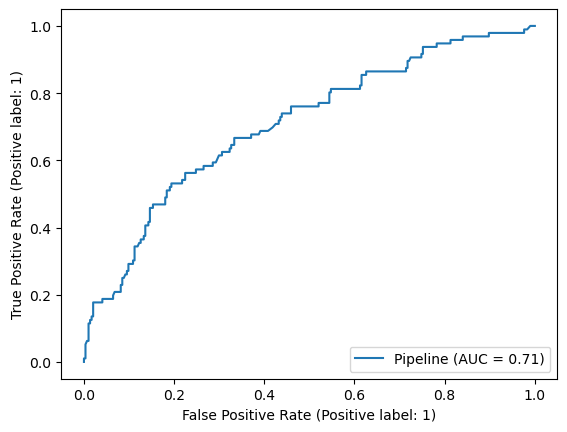

In [10]:
RocCurveDisplay.from_estimator(best_model, X_test, y_test)

For both classes (0 = character survives, 1 = character dies), the model's recall is comparable. However for class 1 the model's precision is much lower, indicating that it is a bit too quick to predict the demise of a character. This could perhaps be improved in future by altering the class weights.

## Discussion

Overall the model's accuracy is fairly unimpressive, correctly predicting the fate of a character in only about half of all cases. While this might seem a bit disappointing, it did not particularly surprise or discourage us: George R. R. Martin is a celebrated author and master story teller, and the fact that we can't easily predict a whether a character will survive based on their attributes is a testament to the quality of his writing rather than the inadequacy of our model. Of course, this prediction tool is largely humerous and unlikely to make much of an impact beyond this project, it is nevertheless interesting to have a quanititative assessment of a plotline's predictability!

## References

Data Society. 2016. Requests: Game of Thrones. https://data.world/data-society/game-of-thrones

Joel Östblom. 2023. DSCI531 Course Notes. https://pages.github.ubc.ca/MDS-2023-24/DSCI_531_viz-1_students/lectures/4-eda.html

Varada Kolhatkar. 2023. DSCI571 Course Notes . https://pages.github.ubc.ca/MDS-2023-24/DSCI_571_sup-learn-1_students/lectures/00_motivation-course-information.html

Joel Östblom. 2023. DSCI573 Course Notes. https://pages.github.ubc.ca/MDS-2023-24/DSCI_573_feat-model-select_students/README.html
